In [23]:
# Import all the necesary libraries 
! pip install torch gym pygame moviepy
import os 
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [24]:
NUM_RUNS = 10 #number of runs

eps_max=1 #max epsilon value
eps_min=0.2 #min epsilon value

#applying decaying-epsilon-greedy algorithm
def eps_decay(step):    
    EPSILON =eps_min + (eps_max - eps_min) * \
        math.exp(-1. * step / 200)  #time-step of 200
    return EPSILON


In [30]:
runs_results = []

#importing CartPole enviroment from OpenAI
env = gym.make('CartPole-v1')

#looping through runs 
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}") #e.g.'Starting running 150 of 5000'
    policy_net = DQN([4,160, 2]) #policy network -- 4-D input, 1 hidden layer of size 160, and 2-D output
    target_net = DQN([4,160, 2]) #target network -- 4-D input, 1 hidden layer of size 160, and 2-D output
    update_target(target_net, policy_net) #takes two DQN objects as arguments and updates the parameters of the *first* one, copying the weights and biases from the second
    target_net.eval()

    #using ADAM as the optimizer as it is adaptative when it comes to learning rate
    ''' lr (our learning rate)  = 0.0001
    ReplayBuffer memory size = 10,000
    '''
    optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
    memory = ReplayBuffer(10000) 
    batch_size = 256

    steps_done = 0

    episode_durations = []

    #looping through 1000 number of episodes:
    '''number of episodes = 1000
    '''
    for i_episode in range(1000): 
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 1000)

        observation, info = env.reset() 
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            
            #Performing epsilon-greedy action
            action = epsilon_greedy(EPSILON, policy_net, state)
            
            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()
            #renew the Q-value after each state after deleting the old one
            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size:
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimizing the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % 30 == 0: 
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')


Starting run 1 of 10
episode  50 / 1000
episode  100 / 1000
episode  150 / 1000
episode  200 / 1000
episode  250 / 1000
episode  300 / 1000
episode  350 / 1000
episode  400 / 1000
episode  450 / 1000
episode  500 / 1000
episode  550 / 1000
episode  600 / 1000
episode  650 / 1000
episode  700 / 1000
episode  750 / 1000
episode  800 / 1000
episode  850 / 1000
episode  900 / 1000
episode  950 / 1000
episode  1000 / 1000
Starting run 2 of 10
episode  50 / 1000
episode  100 / 1000
episode  150 / 1000
episode  200 / 1000
episode  250 / 1000
episode  300 / 1000
episode  350 / 1000
episode  400 / 1000
episode  450 / 1000
episode  500 / 1000
episode  550 / 1000
episode  600 / 1000
episode  650 / 1000
episode  700 / 1000
episode  750 / 1000
episode  800 / 1000
episode  850 / 1000
episode  900 / 1000
episode  950 / 1000
episode  1000 / 1000
Starting run 3 of 10
episode  50 / 1000
episode  100 / 1000
episode  150 / 1000
episode  200 / 1000
episode  250 / 1000
episode  300 / 1000
episode  350 / 100

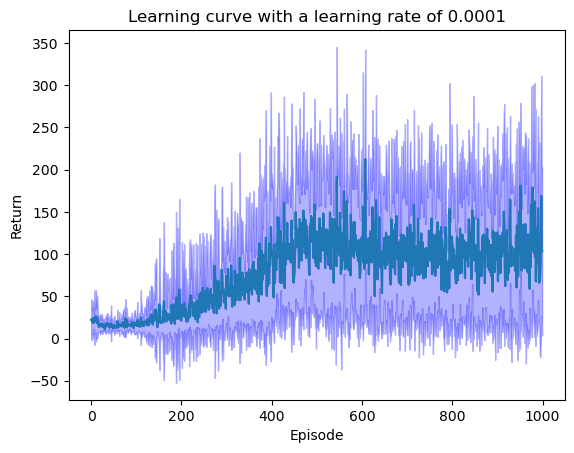

In [36]:
# Plotting the learning curve
 
results = torch.tensor(runs_results)
means = results.float().mean(0)  #finding the mean of the result
stds = results.float().std(0)  #finding the standard deviation of the result

plt.plot(torch.arange(1000), means) #linspace = 1000
plt.title('Learning curve with a learning rate of 0.0001')
plt.ylabel("Return")
plt.xlabel("Episode")

plt.fill_between(torch.arange(1000), means, means+stds, alpha=0.3, color='b')
plt.fill_between(torch.arange(1000), means, means-stds, alpha=0.3, color='b')

plt.savefig('test.png', bbox_inches='tight') #save figure as .png 

plt.show()

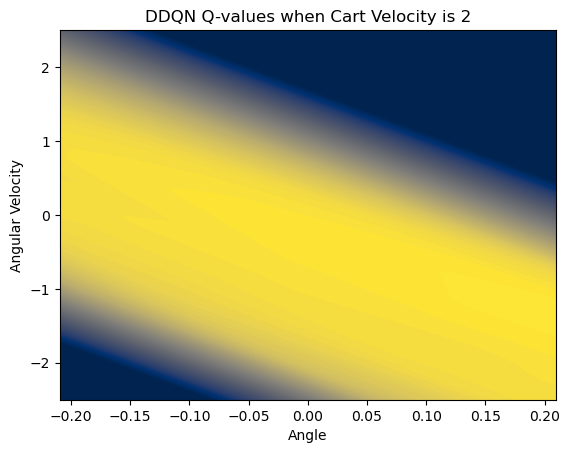

In [67]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots
q = True   # if True, q-values are visiualzed; if False, greedy policy is visualized

angle_range = .2095 #+-12˚ angle range
omega_range = 2.5  # min-max value for angular velocity

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 2, angle, omega]) #([x, y, angle, omega]) --> y = velocity of the cart which can be 0, 0.5, 1 and 2.
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
    
plt.xlabel("Angle")
plt.ylabel("Angular Velocity")
plt.title('DDQN Q-values when Cart Velocity is 2') #if q = True, title = 'Q-values when Cart Velocity = ?'
plt.savefig('ddqn_Q2.png')  #save figures as .png file
plt.show()